In [425]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import docplex.cp.utils_visu as visu

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3
import random
import sys
sys.path.append("..")
from utils import extract_solution

Taillard specification

On the first line are two numbers, the first is the number of jobs and the second the number of machines. Following there are two matrice the first with a line for each job containing the processor times for each operation the second with the order for visiting the machines. The numbering of the machines starts at 1.

For example the same instance as above would be presented as:

1	3	

6	7	5

2	3	1


More info, and data source:

http://jobshop.jjvh.nl/index.php

In [426]:
case = 'orb10'

In [427]:
Text =[]
with open("data/"+case+".txt") as f:
    for line in f:
        Text.append(line)

firstline = Text[0].split('\t')
num_jobs = int(firstline[0])
num_machines = int ( firstline[1].replace('\n',"") )

durations =[]
for i in range(1,num_jobs+1):
    a= Text[i].split('\t')
    durations.append( [int(j) for j in a])
durations = pd.DataFrame(durations)
display(durations)


machines =[]
for i in range(num_jobs+1,2*num_jobs+1):
    a= Text[i].split('\t')
    machines.append( [int(j) for j in a])
machines = pd.DataFrame(machines)
display(machines)

,0,1,2,3,4,5,6,7,8,9
0,66,13,93,91,14,70,99,53,86,16
1,34,99,62,65,62,64,21,12,9,75
2,12,26,64,92,67,28,66,83,38,58
3,77,73,82,75,84,19,18,89,8,73
4,34,74,48,44,92,40,60,62,22,67
5,8,85,58,97,92,89,75,77,95,5
6,52,43,5,78,12,62,21,80,60,31
7,81,23,23,75,78,56,51,39,53,96
8,79,55,88,21,83,93,47,10,63,14
9,43,63,83,29,52,98,54,39,33,23


,0,1,2,3,4,5,6,7,8,9
0,10,9,1,8,7,6,4,3,5,2
1,9,10,1,8,6,5,7,3,4,2
2,10,9,8,7,5,6,4,3,2,1
3,1,2,4,3,7,5,6,8,9,10
4,1,2,8,6,5,7,4,3,9,10
5,10,9,4,8,6,5,7,3,2,1
6,9,10,7,8,6,4,5,3,2,1
7,10,9,8,7,5,6,4,3,2,1
8,10,9,3,5,6,4,7,8,1,2
9,1,2,3,4,5,6,7,8,9,10


In [428]:
durations = \
durations.melt(ignore_index=False).reset_index(drop = False)
data = durations.rename(columns = {"index":"job",'variable':"operation","value":"duration"}).sort_values(['job','operation'])
data.head()

,job,operation,duration
0,0,0,66
10,0,1,13
20,0,2,93
30,0,3,91
40,0,4,14


In [429]:
machines = machines.melt(ignore_index=False).reset_index(drop = False).rename(columns = {"index":"job",'variable':"operation","value":"machine"}).reset_index(drop = True).sort_values(['job','operation'])
machines.head()

,job,operation,machine
0,0,0,10
10,0,1,9
20,0,2,1
30,0,3,8
40,0,4,7


In [430]:
data = pd.merge(data, machines, on= ['job','operation']).sort_values(['job','operation'])
data.head()

,job,operation,duration,machine
0,0,0,66,10
1,0,1,13,9
2,0,2,93,1
3,0,3,91,8
4,0,4,14,7


In [431]:
horizon = data['duration'].sum()

mdl = CpoModel(name="Taillard")

DV=[]
for row in data.itertuples():

    dv = mdl.interval_var((0, horizon) , (0, horizon) , size=row.duration, name="Job{}:Oper{}:Mach{}".format(row.job, row.operation, row.machine))
    DV.append(dv) 
data['DV'] = DV
data.head()

,job,operation,duration,machine,DV
0,0,0,66,10,"""Job0:Oper0:Mach10"" = intervalVar(start=0..5549, end=0..5549, size=66)"
1,0,1,13,9,"""Job0:Oper1:Mach9"" = intervalVar(start=0..5549, end=0..5549, size=13)"
2,0,2,93,1,"""Job0:Oper2:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=93)"
3,0,3,91,8,"""Job0:Oper3:Mach8"" = intervalVar(start=0..5549, end=0..5549, size=91)"
4,0,4,14,7,"""Job0:Oper4:Mach7"" = intervalVar(start=0..5549, end=0..5549, size=14)"


In [432]:
# machines are allocated to one job at a time

jobs_same_machine = data[['machine','DV']].groupby('machine').agg(list).reset_index(drop=False)

display(jobs_same_machine.head(1))

for row in jobs_same_machine.itertuples():
    mdl.add ( mdl.no_overlap(  row.DV ))

,machine,DV
0,1,"[""Job0:Oper2:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=93), ""Job1:Oper2:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=62), ""Job2:Oper9:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=58), ""Job3:Oper0:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=77), ""Job4:Oper0:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=34), ""Job5:Oper9:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=5), ""Job6:Oper9:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=31), ""Job7:Oper9:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=96), ""Job8:Oper8:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=63), ""Job9:Oper0:Mach1"" = intervalVar(start=0..5549, end=0..5549, size=43)]"


In [433]:
# precedence
jobs = data['job'].unique()

for job in jobs:

    u = data[data['job']==job].reset_index(drop=True)
    u['order']= range(1, len(u)+1)
    m = len(u)

    precedence_list = [[i,i+1] for i in range(1,m+1)][:-1]
    for i in precedence_list:
        first_task = u[u['order']==i[0]]['DV'].values[0]
        second_task = u[u['order']==i[1]]['DV'].values[0]
        #print( first_task,second_task )
        mdl.add( mdl.end_before_start(first_task  , second_task ))

In [434]:
data.loc[:,'endtime']=data['DV'].apply(lambda x:mdl.end_of(x))

obj = mdl.minimize ( mdl.max ( data['endtime']) )

mdl.add(obj)

In [435]:
msol = mdl.solve(TimeLimit=50, trace_log=False)

msol.get_objective_values()

(944,)

In [436]:
data['DV_sol'] = data['DV'].apply(lambda x:msol.get_var_solution(x))
data['DV_sol_start']=data['DV_sol'].apply(lambda x:x.get_start())
data['DV_sol_end']=data['DV_sol'].apply(lambda x:x.get_end())

data.sort_values(['DV_sol_end','DV_sol_start']).tail()

,job,operation,duration,machine,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
98,9,8,33,9,"""Job9:Oper8:Mach9"" = intervalVar(start=0..5549, end=0..5549, size=33)","endOf(""Job9:Oper8:Mach9"")","Job9:Oper8:Mach9: (start=873, end=906, size=33, length=33)",873,906
49,4,9,67,10,"""Job4:Oper9:Mach10"" = intervalVar(start=0..5549, end=0..5549, size=67)","endOf(""Job4:Oper9:Mach10"")","Job4:Oper9:Mach10: (start=852, end=919, size=67, length=67)",852,919
8,0,8,86,5,"""Job0:Oper8:Mach5"" = intervalVar(start=0..5549, end=0..5549, size=86)","endOf(""Job0:Oper8:Mach5"")","Job0:Oper8:Mach5: (start=842, end=928, size=86, length=86)",842,928
99,9,9,23,10,"""Job9:Oper9:Mach10"" = intervalVar(start=0..5549, end=0..5549, size=23)","endOf(""Job9:Oper9:Mach10"")","Job9:Oper9:Mach10: (start=919, end=942, size=23, length=23)",919,942
9,0,9,16,2,"""Job0:Oper9:Mach2"" = intervalVar(start=0..5549, end=0..5549, size=16)","endOf(""Job0:Oper9:Mach2"")","Job0:Oper9:Mach2: (start=928, end=944, size=16, length=16)",928,944


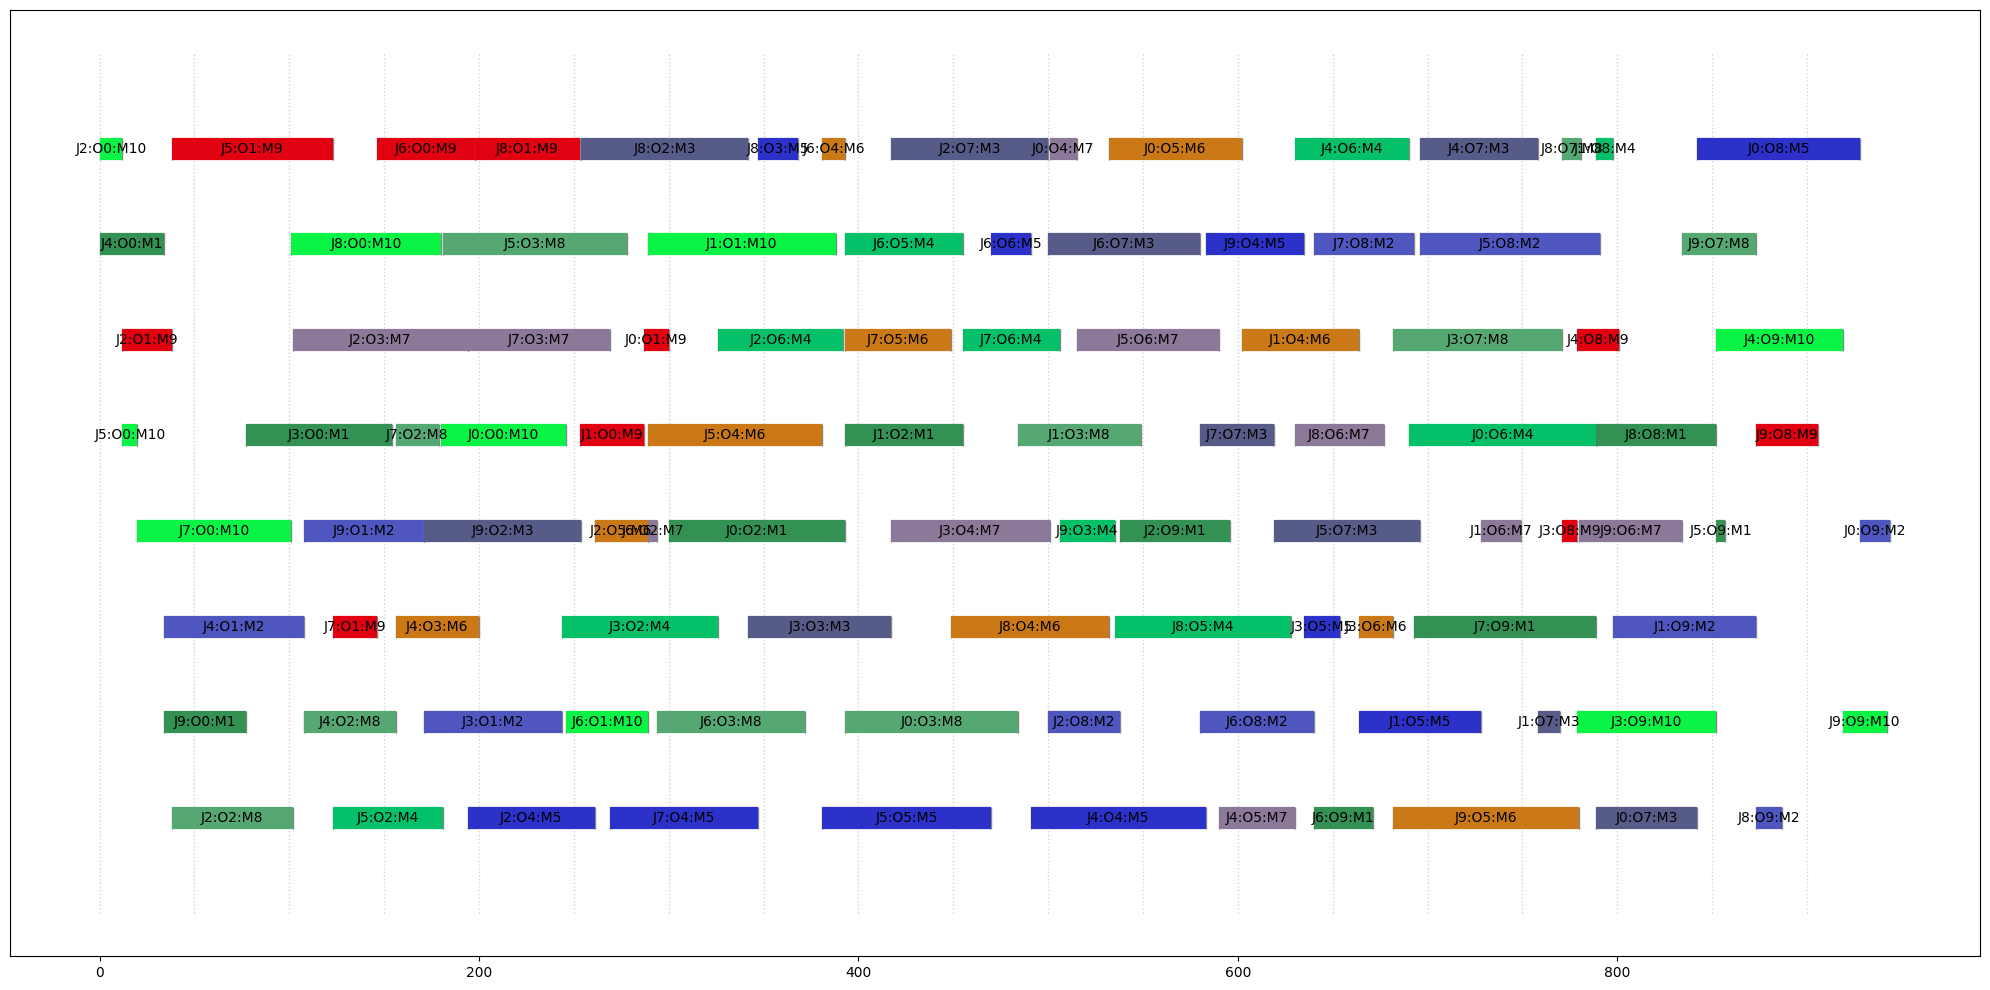

In [437]:
#random colors

colors_ = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = dict(zip([str(i) for i in range(1,num_machines+1)],  [colors_(1)[0] for i in range(1,num_machines+1)]))
#colors ={'0':'yellow',   '1':'lightblue', '2':  'lightgreen','3' :'cyan' ,'4':'linen','5':'green',"6":'ivory'}

rcParams['figure.figsize'] = 20, 10

for i in data['DV'].values:
    wt = msol.get_var_solution(i)
    job = wt.get_name().split(':')[0].replace("Job","J")
    operation = wt.get_name().split(':')[1].replace("Oper","O")
    machine = wt.get_name().split(':')[2].replace("Mach","M")

    visu.interval(wt, colors[machine.replace("M","")], ':'.join([job, operation, machine])) 

visu.show()